In [130]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
%matplotlib inline
import glob
from astropy.io.fits import getdata, getheader
from astropy.time import Time
import astropy.units as u


In [2]:
# Setup NuSTAR time epochs:
launch_met=77241600. # 2012-06-13T00:00:00

from astropy.convolution import convolve, Box1DKernel


In [3]:
# Step one, sort all of the data if you haven't done this already:

for ind, file in enumerate(glob.glob('../full_mission/*A_02*')):
    # Load the header:
    hdr = getheader(file, 1)
#    dt_weeks = np.floor((hdr['TSTART'] - launch_met) / (7 * 86400.))
#    print(dt_weeks)
    stub= {'TSTART':np.float(hdr['TSTART']),
           'FNAME':file,
           'DATE-OBS':hdr['DATE-OBS']}
    if(ind==0):
        dbase = [stub]
    else:
        dbase.append(stub)


    

df = pd.DataFrame(dbase)
df_sorted = df.sort_values(by='TSTART')



In [132]:
nustar_mjdref = Time(55197, format='mjd')


'2010-01-01 00:01:40.000'

In [198]:
def show_map2(data, exposure, num=False, savefigs=False, aspect=8, title = False):
    fig = plt.figure(figsize=(16, 4))

    if title is False:
        if num is not False:
            title = 'Weeek {}'.format(num)
        else:
            title = 'Weekly'
    ax = fig.add_subplot(111, title=title)
    plt.imshow(
                data/exposure,
                interpolation='nearest', origin='low',
                cmap=cm.jet, extent=[0, 360, -6.5, 6.5],
                aspect=aspect,
                norm=colors.LogNorm(vmin=1, vmax = 20.))
#    plt.colorbar()

    if savefigs:
        plt.savefig('week_{}.png'.format(num))
    plt.show()



In [209]:
interval = 30.*86400. # Monthly
reset_interval=1

nlatbins = 48
nlonbins = 360
aspect = nlatbins / nlonbins


lon_scale = 360 / nlonbins
lat_scale = 13 / nlatbins 

aspect = 2.0*lon_scale / lat_scale


/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


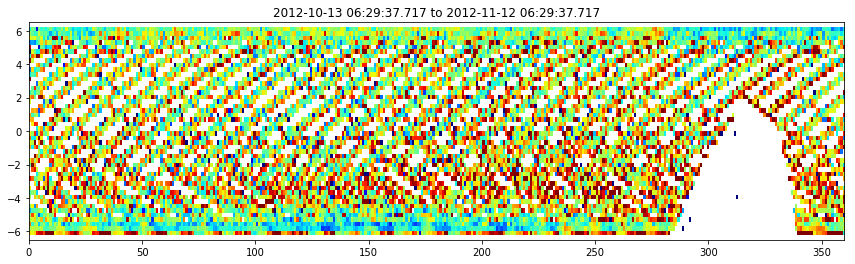

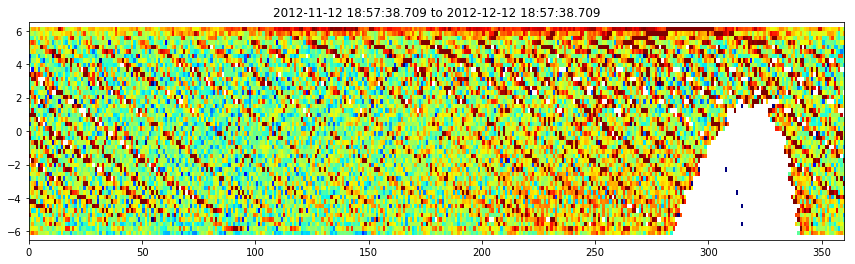

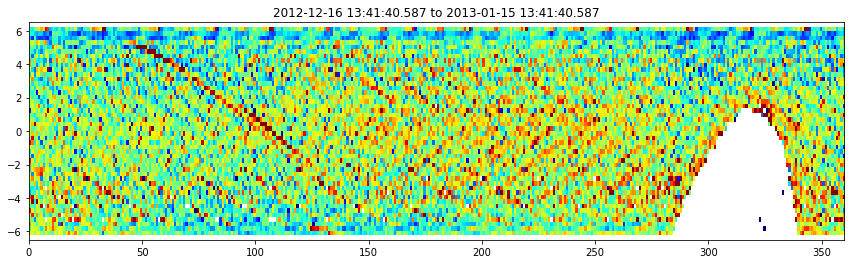

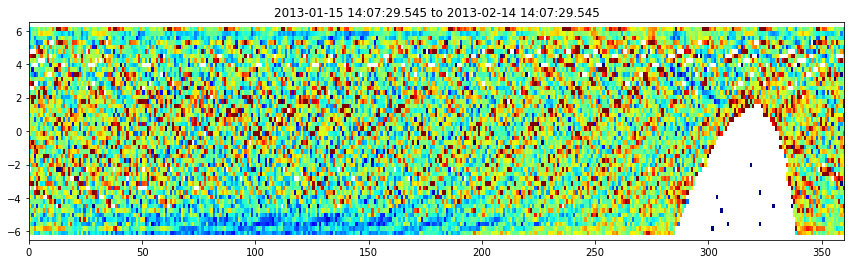

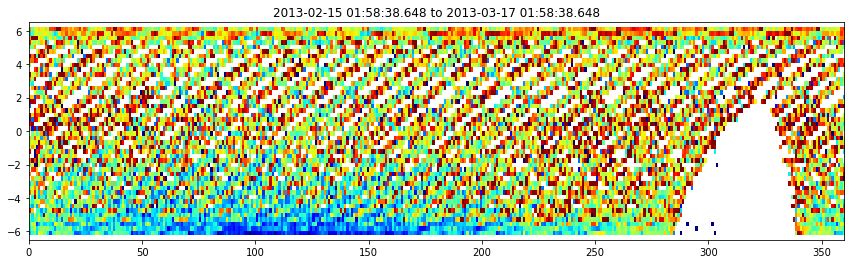

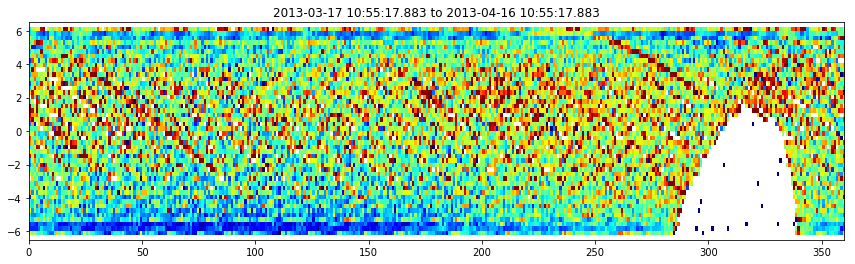

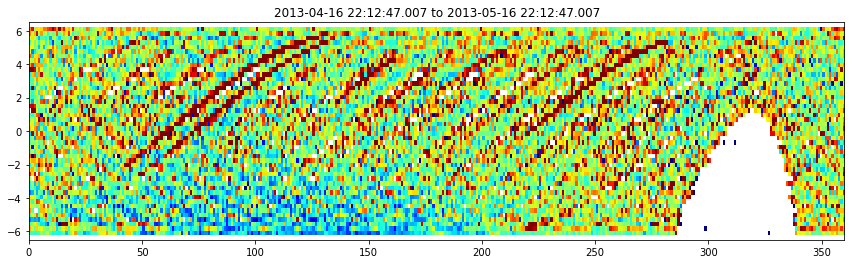

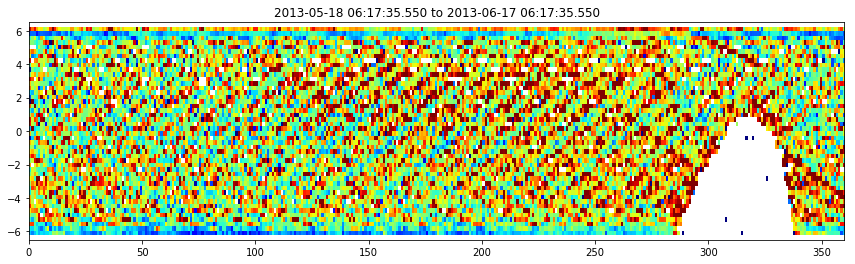

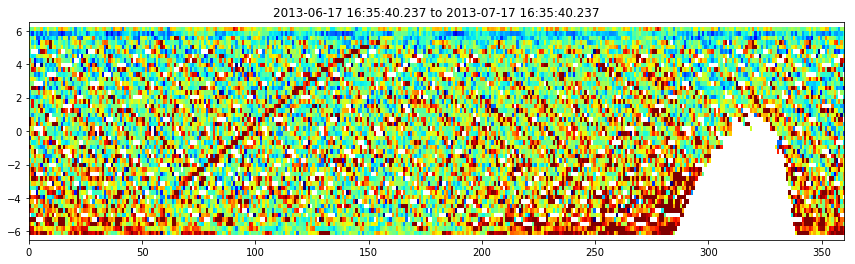

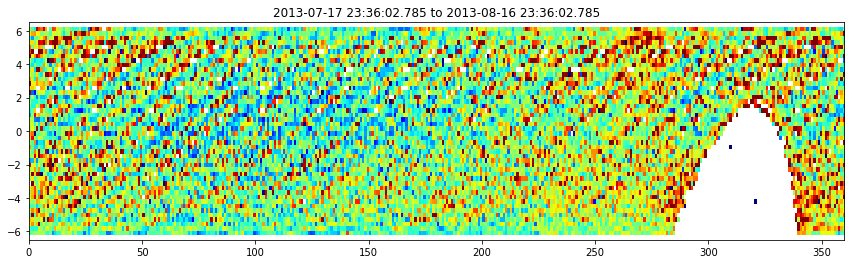

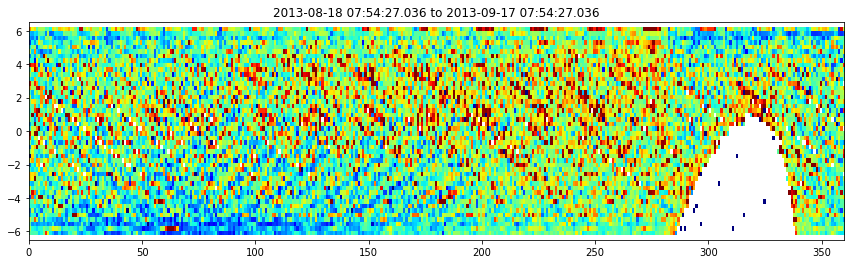

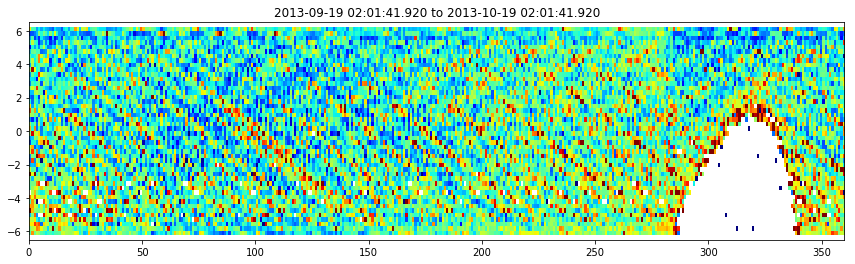

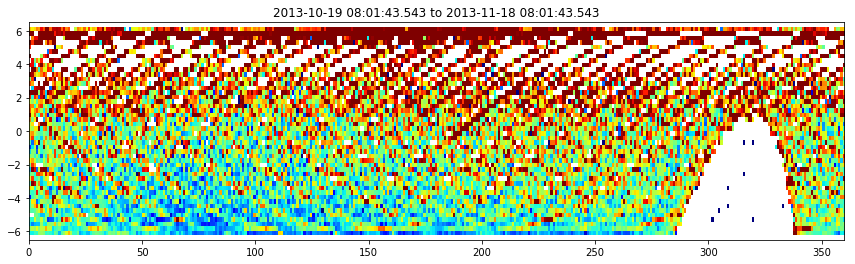

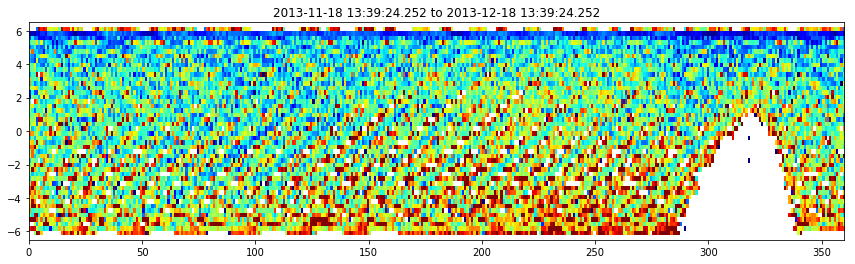

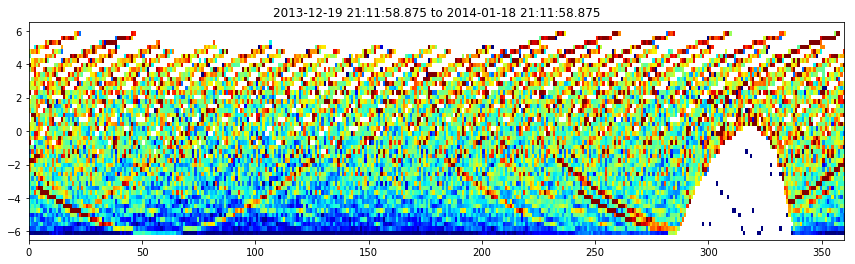

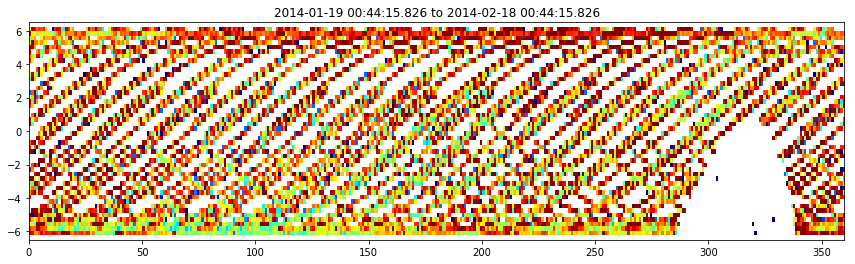

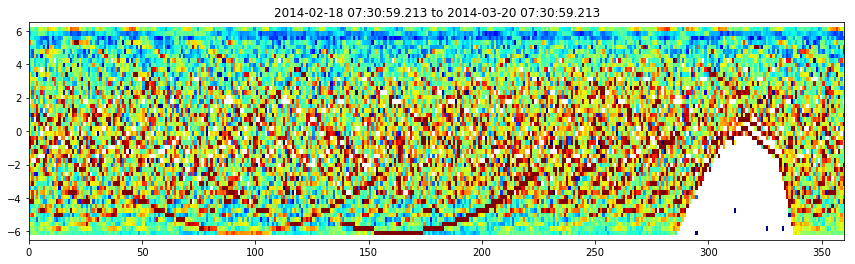

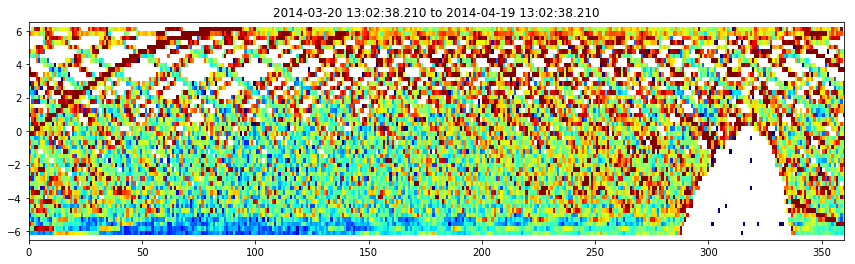

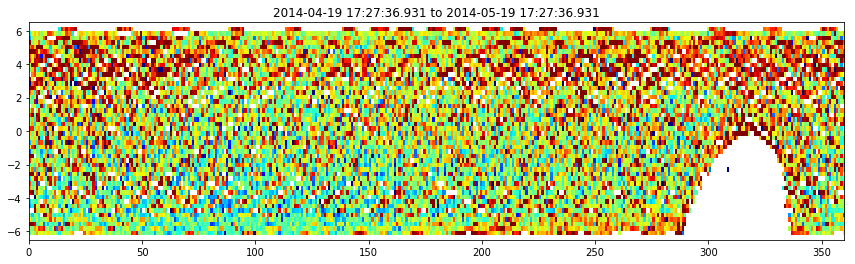

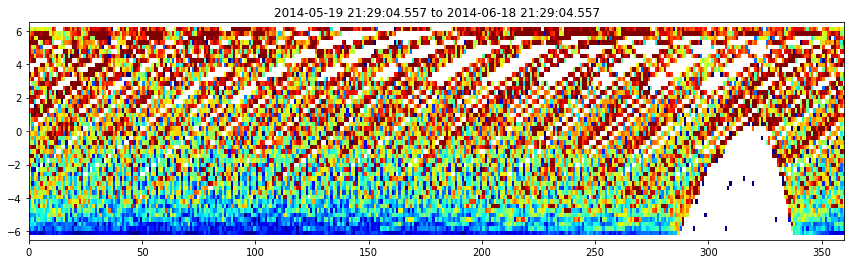

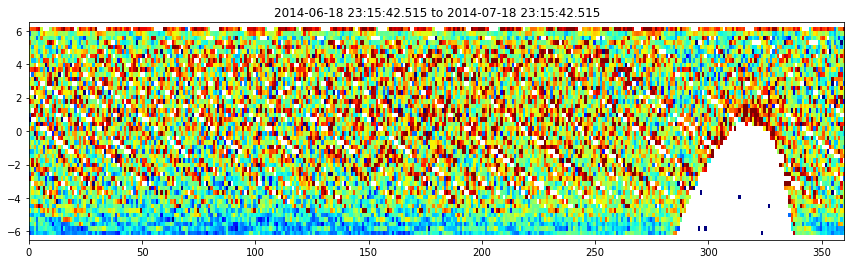

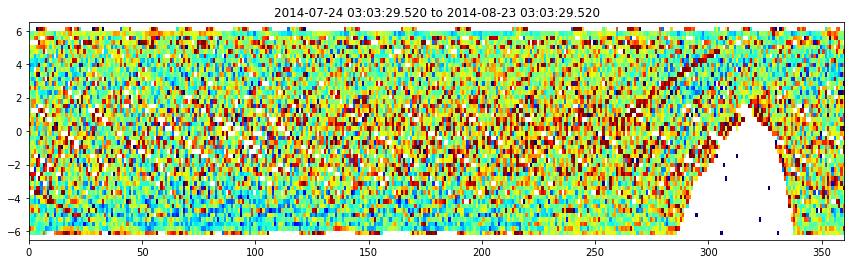

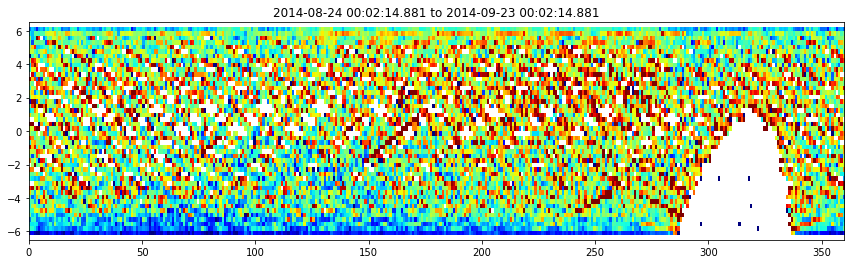

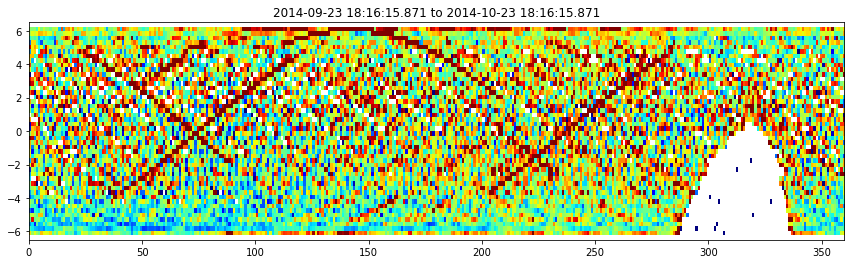

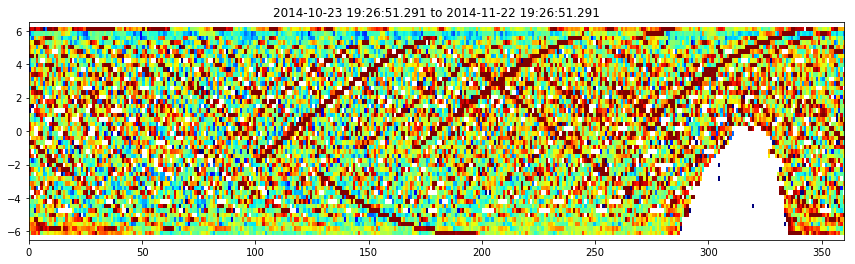

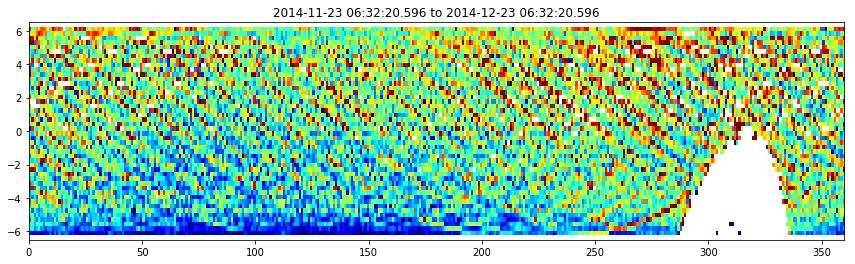

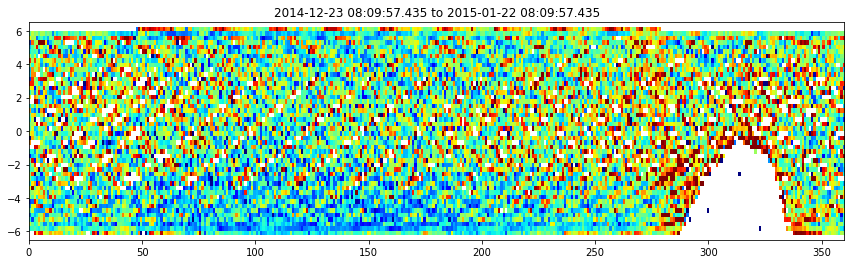

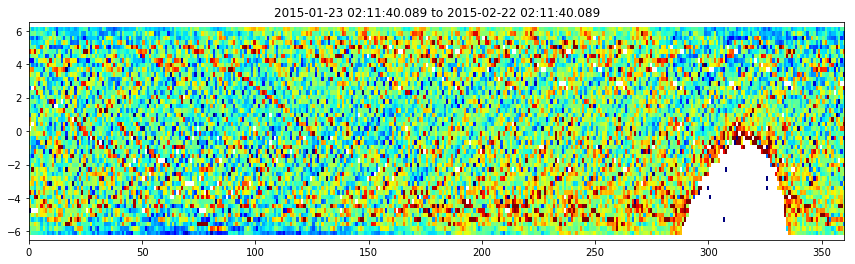

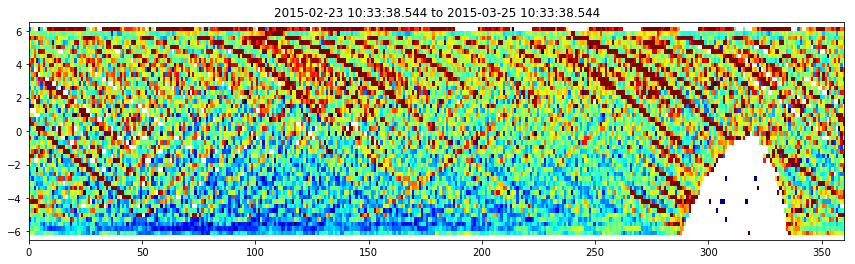

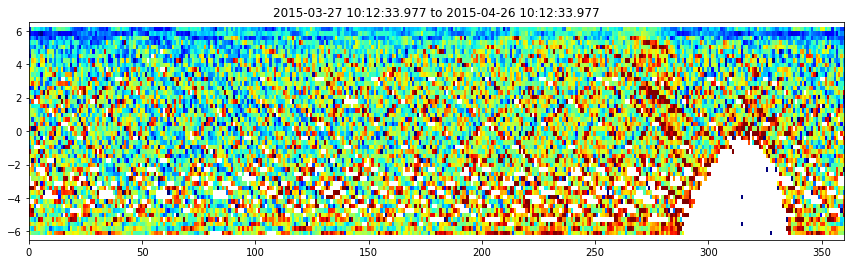

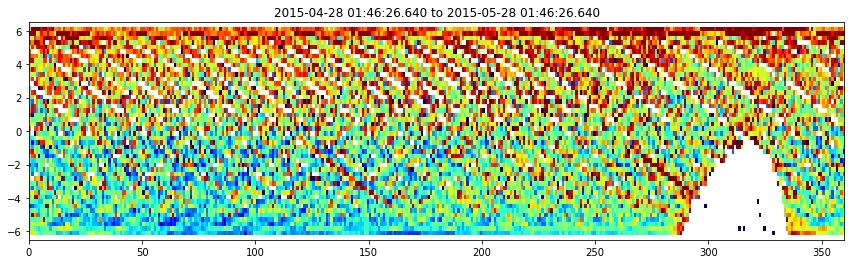

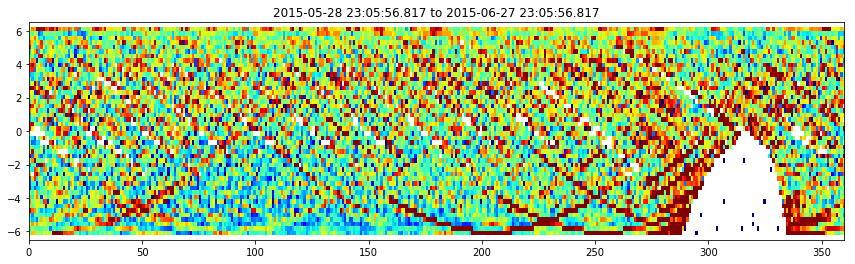

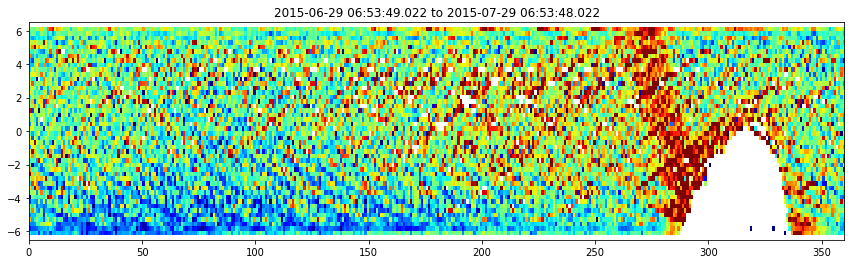

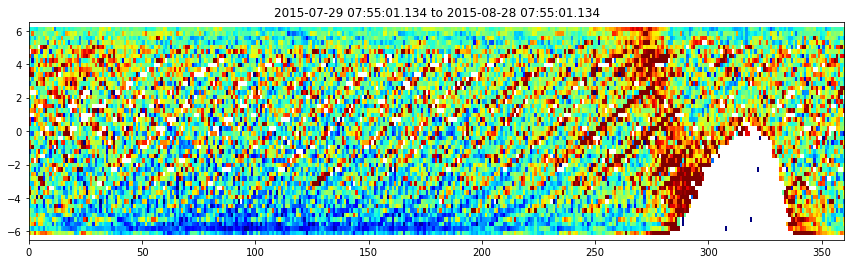

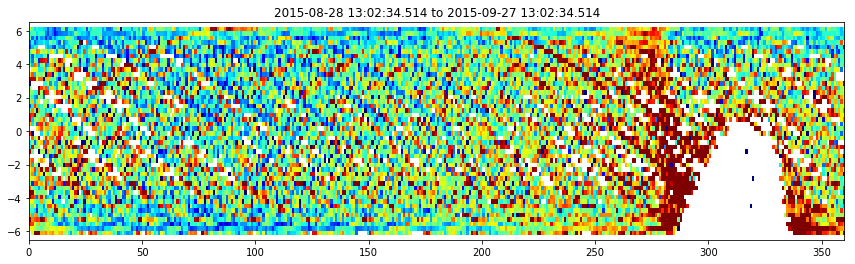

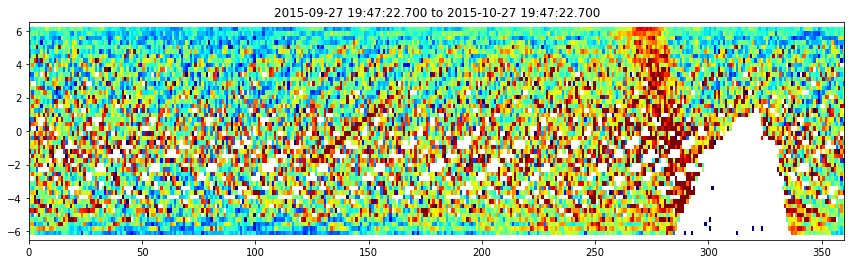

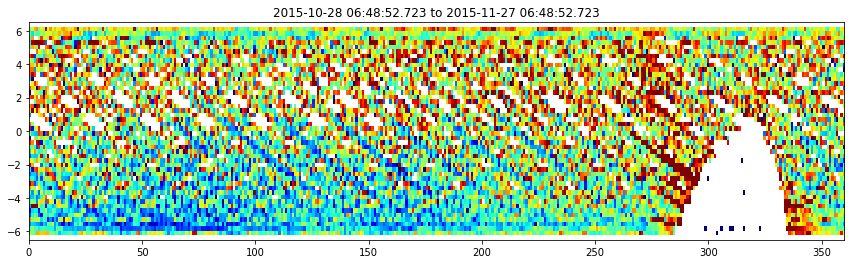

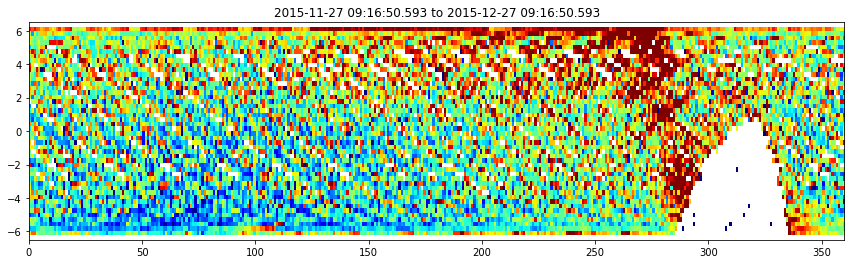

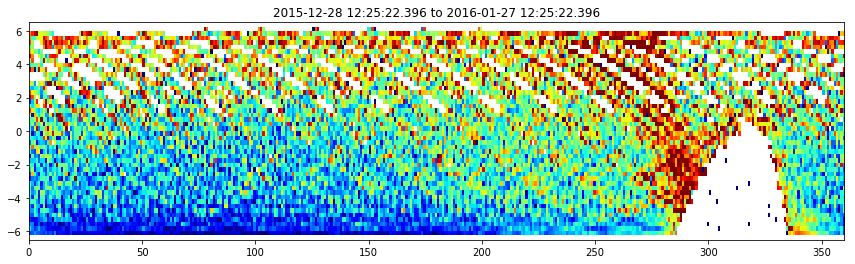

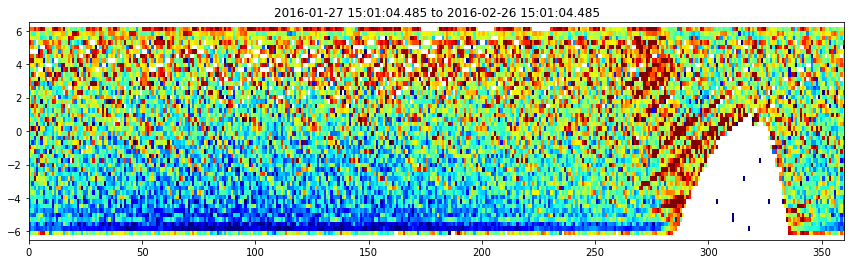

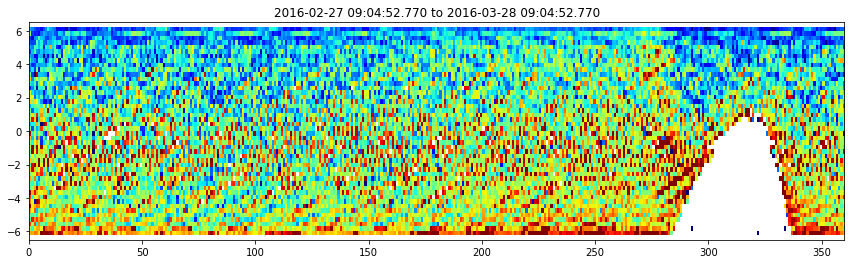

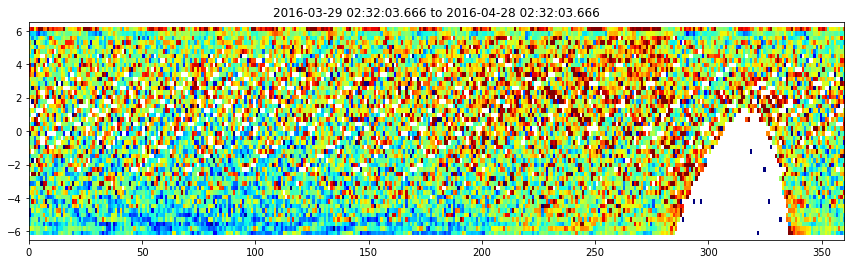

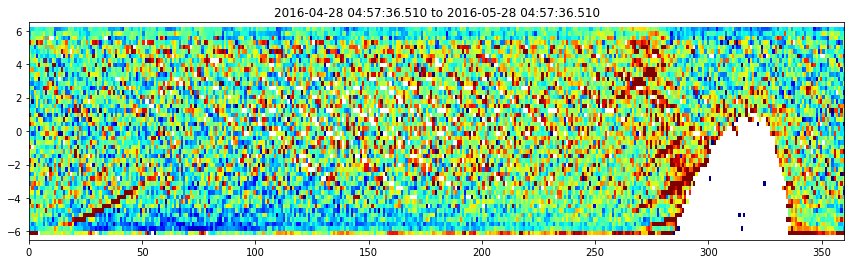

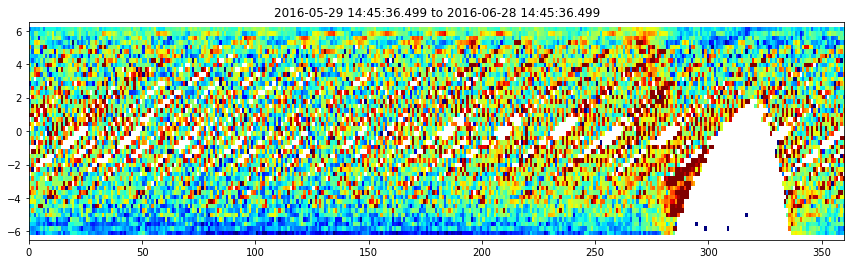

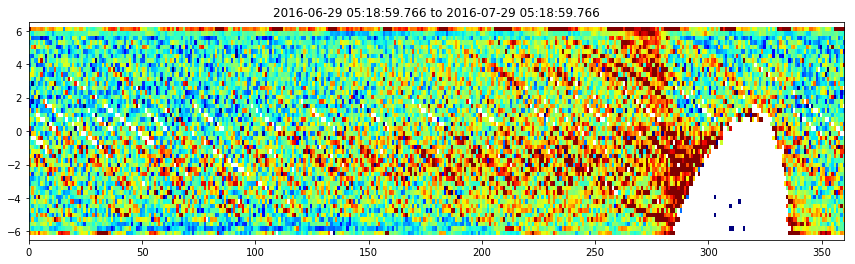

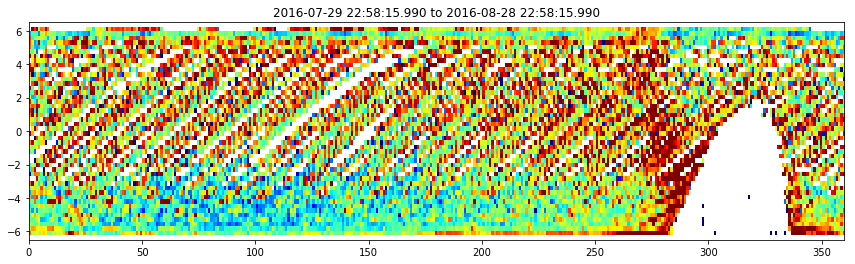

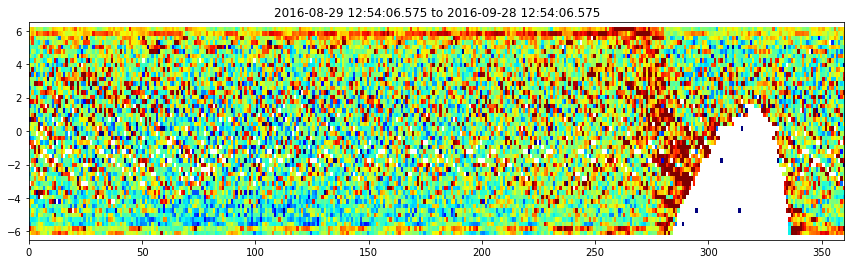

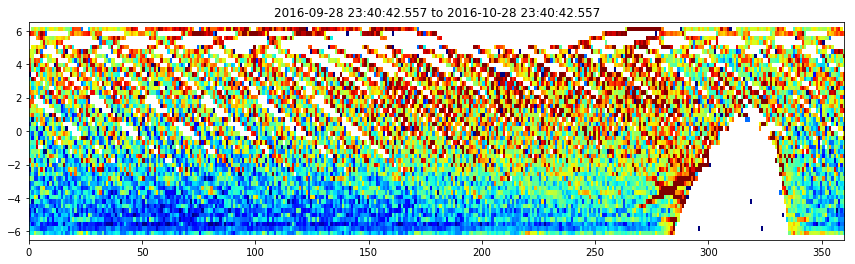

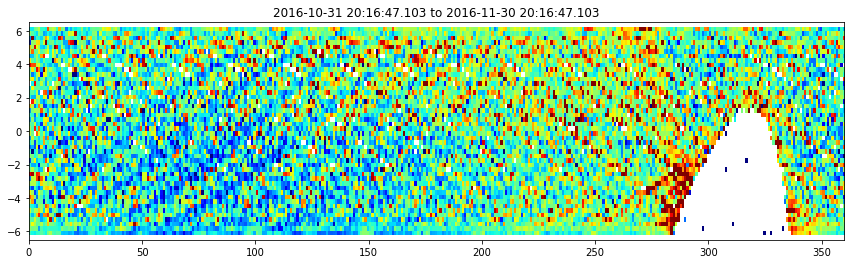

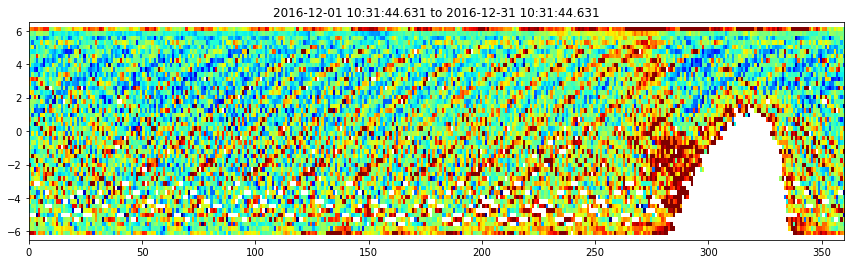

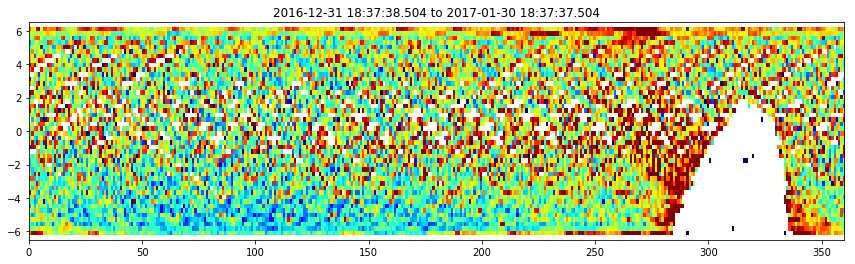

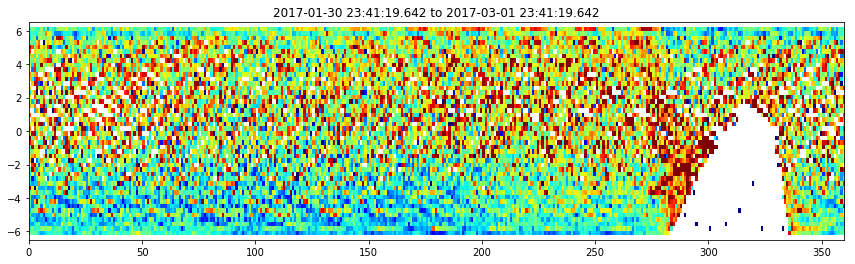

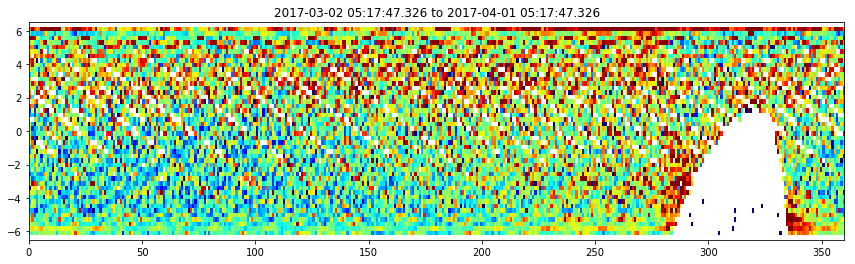

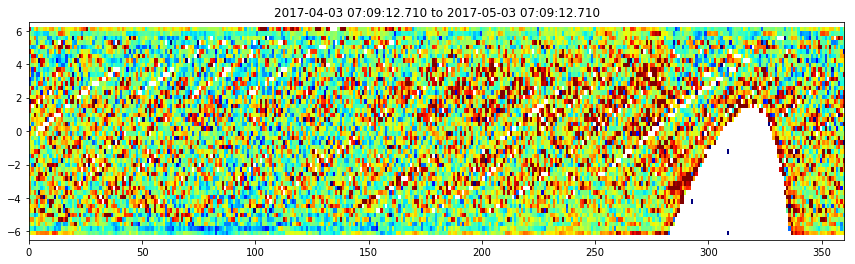

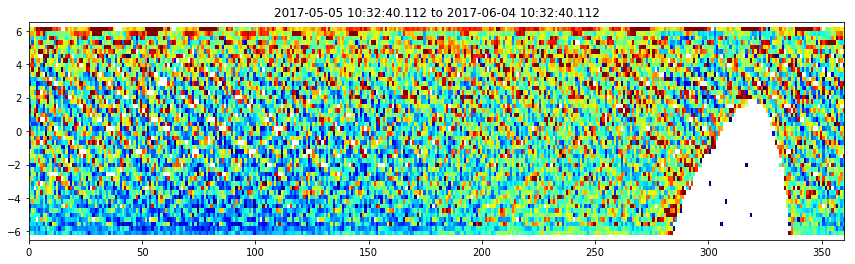

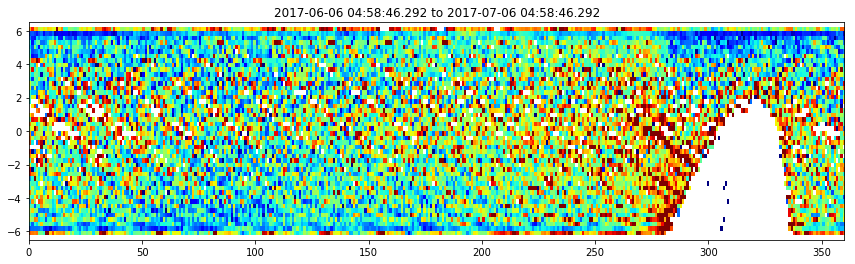

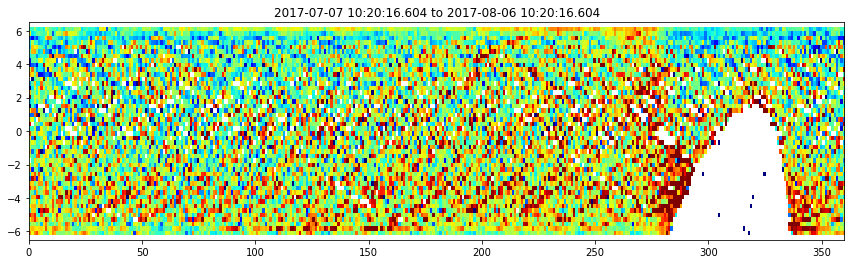

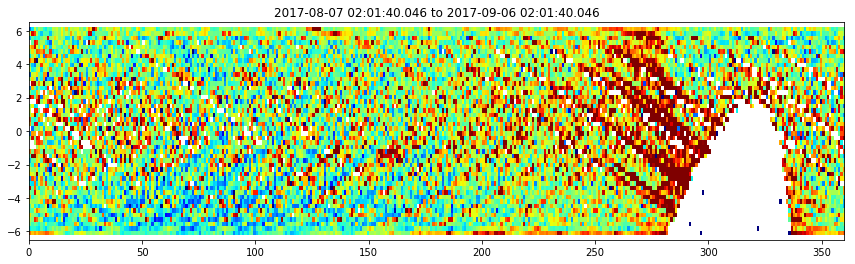

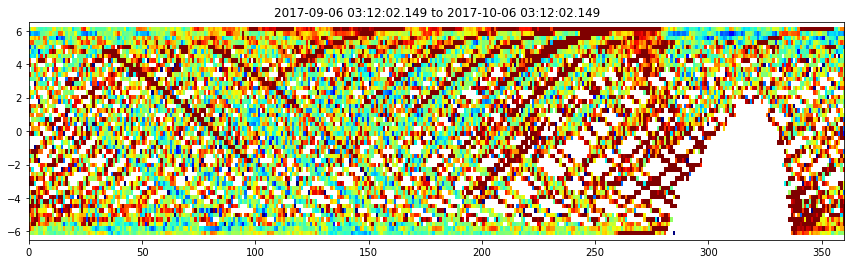

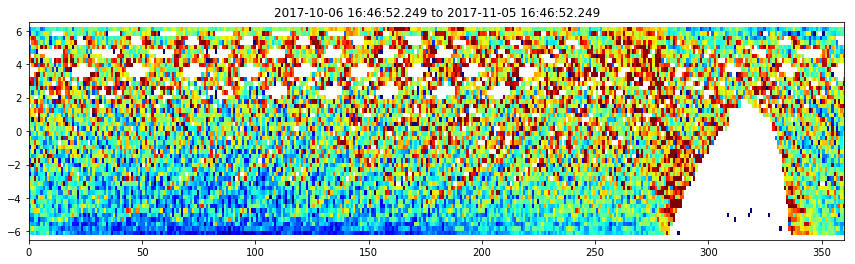

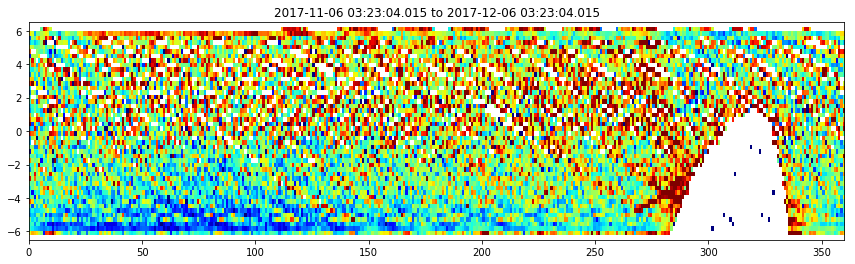

In [210]:
ctr = 0
for ind, file in enumerate(df_sorted['FNAME']):
    
    if (ind < 100):
        continue
    evt = getdata(file, 1)
    hdr = getheader(file, 1)
    if(reset_interval == 1):
        tmin = evt['TIME'].min()

    time_filter=( ((evt['TIME'] - tmin) < interval) & (evt['LIMB_ANGLE'] < 0)).nonzero()
    thismap, xedges, yedges = np.histogram2d(evt['LON'][time_filter],
                             evt['LAT'][time_filter],
                             range = [[0, 360], [-6.5, 6.5]],
                             bins=[nlonbins, nlatbins])
#    plt.scatter(evt['LON'][time_filter], evt['LAT'][time_filter])

    if(reset_interval == 1):
        tmin = evt['TIME'].min()
        reset_interval=0
        allmap = thismap
        exposure = np.zeros_like(allmap)
    else:
        allmap+=thismap  
        filled = (thismap > 0).nonzero()
        exposure[filled] += 1.0

    if(max(evt['TIME']) > tmin + interval):    
        filled = (exposure > 0).nonzero()
        allmap[filled] = allmap[filled] / exposure[filled]

        plotmap = allmap.T
        plotexp = exposure.T

        empty =(plotmap == 0).nonzero()
        plotmap[empty]=np.nan
        plotexp[empty] = np.nan

        tstart = nustar_mjdref+tmin*u.s
        tend = nustar_mjdref + (tmin+interval)*u.s
        title = "{} to {}".format(tstart.iso, tend.iso)


        show_map2(plotmap, plotexp, num=ctr, aspect=aspect, savefigs=True, title = title )
        ctr +=1
        reset_interval=1
        


In [ ]:
def show_map(map, exposure):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(211, title='imshow: square bins')
    plt.imshow(
                map,
                interpolation='nearest', origin='low',
                cmap=cm.jet, extent=[0, 360, -6.5, 6.5],
                aspect=8,
                norm=colors.LogNorm(vmin=1.0, vmax = 100.))
    plt.colorbar()

    ax = fig.add_subplot(212, title='imshow: square bins')
#     plt.show()

    plt.imshow(
                exposure,
                interpolation='nearest', origin='low',
                cmap=cm.jet, extent=[0, 360, -6.5, 6.5],
                aspect=8,vmin=1.0, vmax =5.)
    plt.colorbar()
    plt.show()
#     plt.close(fig)
    input("Press Enter to continue...")
    fig.clf()    

#plt.set_ytick(yedges)

#plt.gca().set_yticks(yedges)
# ax = fig.add_subplot(132, title='pcolormesh: actual edges',
#         aspect='equal')
# X, Y = np.meshgrid(xedges, yedges)
# ax.pcolormesh(X, Y, thismap)

#ax = fig.add_subplot(133, title='Scatter', aspect = 15)
#plt.scatter(evt['LON'][time_filter], evt['LAT'][time_filter])
#plt.xlim(0, 360)
#plt.ylim(-12, 12)
